In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import requests
import folium
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import numpy as np
from folium.plugins import HeatMap
from scipy.spatial.distance import pdist, squareform
from folium.plugins import MarkerCluster
from IPython.display import display
import glob
import os
import geopandas as gpd
import contextily as ctx
import zipfile
from shapely.geometry import Point



In [2]:
df = pd.read_csv('Toronto Bikeshare May2023 - Apr2024.csv')

# Toronto Bikeshare Demand Analysis
## Data Preparation and Feature Engineering

This notebook processes Toronto's bikeshare trip data to create an hourly demand forecasting dataset. The analysis focuses on station outflows (number of trips starting from each station) on an hourly basis.

### Dataset Overview

The original dataset contains 5,336,042 bike trip records with 28 columns, including:
- Trip details (start/end times, stations, duration)
- Bike information (ID, model)
- User information (user type)
- Geographical data (station coordinates)
- Weather conditions (temperature, precipitation, wind, etc.)



### Data Processing Pipeline

Our processing pipeline consists of several key functions that transform the raw trip data into a structured hourly demand dataset:

#### 1. `create_base_hourly_outflows(df)`
Creates the core hourly outflow dataset by:
- Converting date and hour to datetime format
- Extracting station locations
- Aggregating weather data
- Calculating hourly outflow counts
- Creating a complete time series for each station
- Merging all components into a base dataset

Key transformations:
- Fills missing outflow counts with 0
- Forward/backward fills categorical variables within each station
- Standardizes column names

#### 2. `add_time_features(df)`
Enhances the dataset with temporal features:
- Basic time components (year, month, day, hour)
- Day of week (both name and number)
- Weekend indicator (0/1)
- Time periods:
  - Late Night (12AM-6AM)
  - Morning (6AM-12PM)
  - Midday (12PM-5PM)
  - Evening (5PM-9PM)
  - Night (9PM-12AM)

#### 3. `add_moving_averages(df)`
Calculates rolling statistics for each station:
- 3-hour moving average (short-term trends)
- 24-hour moving average (daily patterns)
- Weekly moving average (168 hours, weekly patterns)

#### 4. `prepare_final_dataset(df)`
Combines all processing steps and organizes the final dataset with:
- Temporal features
- Station information
- Demand metrics
- Weather conditions

#### 5. `check_dataset_quality(df)`
Performs quality assurance by checking:
- Dataset dimensions
- Time coverage
- Missing values
- Station count
- Basic outflow statistics

### Final Dataset Structure

The processed dataset includes the following feature categories:

1. **Temporal Features**
   - DateTime, Date, Year, Month, Day of Week, Hour
   - Weekend indicator
   - Time period classification

2. **Station Information**
   - Station name
   - Geographical coordinates (latitude, longitude)

3. **Usage Patterns**
   - Hourly outflow counts
   - Moving averages (3H, 24H, Week)
   - User type
   - Bike model

4. **Weather Conditions**
   - Temperature
   - Precipitation
   - Wind (speed and direction)
   - Cloud cover
   - Humidity
   - Pressure
   - Dew point

### Usage Notes

- The dataset maintains hourly granularity for all stations
- Missing values are handled appropriately for each feature type
- Weather data is consistent across all stations for each hour
- Station locations are treated as static throughout the analysis period

This processed dataset provides a robust foundation for demand forecasting analysis, capturing temporal patterns, weather influences, and station-specific characteristics.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5336042 entries, 0 to 5336041
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Start Time           object 
 1   Start Station Name   object 
 2   End Station Id       float64
 3   End Time             object 
 4   End Station Name     object 
 5   Bike Id              int64  
 6   User Type            object 
 7   lat_start            float64
 8   lon_start            float64
 9   lat_end              float64
 10  lon_end              float64
 11  Model                object 
 12  Trip Duration (min)  float64
 13  Hour                 int64  
 14  Day of Week          object 
 15  Month                object 
 16  Date                 object 
 17  Distance (km)        float64
 18  Speed (km/h)         float64
 19  Station Pair         object 
 20  Temperature          float64
 21  Dew Point            float64
 22  Relative Humidity    float64
 23  Precipitation        float64
 24

In [4]:
def create_base_hourly_outflows(df):
    """
    Creates the core hourly outflow dataset for each station with properly filled weather and location data.
    
    Parameters:
    df (pandas.DataFrame): Original bike trip dataset
    
    Returns:
    pandas.DataFrame: Complete hourly dataset with filled values
    """
    # Convert Date and Hour to DateTime
    df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    
    # Get station locations (should be constant for each station)
    station_locations = df.groupby('Start Station Name').agg({
        'lat_start': 'first',
        'lon_start': 'first'
    }).reset_index()
    
    # Get hourly weather data (should be same for all stations in each hour)
    weather_data = df.groupby('DateTime').agg({
        'Temperature': 'first',
        'Precipitation': 'first',
        'Wind Speed': 'first',
        'Cloud Cover': 'first',
        'Dew Point': 'first',
        'Relative Humidity': 'first',
        'Wind Direction': 'first',
        'Pressure': 'first'
    }).reset_index()
    
    # Calculate hourly outflow counts and aggregate categorical data
    outflow_data = df.groupby(['Start Station Name', 'DateTime']).agg({
        'Bike Id': 'count',  # This will be our Outflow_Count
        'User Type': lambda x: x.mode().iloc[0] if not x.empty else None,  # Most common user type
        'Model': lambda x: x.mode().iloc[0] if not x.empty else None  # Most common bike model
    }).reset_index()
    
    outflow_data = outflow_data.rename(columns={'Bike Id': 'Outflow_Count'})
    
    # Create complete time range for each station
    stations = df['Start Station Name'].unique()
    start_date = df['DateTime'].min()
    end_date = df['DateTime'].max()
    
    # Create all station-hour combinations
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    station_hours = pd.MultiIndex.from_product([stations, date_range], 
                                             names=['Start Station Name', 'DateTime'])
    base_df = pd.DataFrame(index=station_hours).reset_index()
    
    # Merge all data
    # 1. Merge with station locations
    base_df = base_df.merge(station_locations, on='Start Station Name', how='left')
    
    # 2. Merge with weather data
    base_df = base_df.merge(weather_data, on='DateTime', how='left')
    
    # 3. Merge with outflow data
    base_df = base_df.merge(outflow_data, on=['Start Station Name', 'DateTime'], how='left')
    
    # Fill missing values
    base_df['Outflow_Count'] = base_df['Outflow_Count'].fillna(0)
    # Forward fill categorical variables within each station
    for station in stations:
        mask = base_df['Start Station Name'] == station
        base_df.loc[mask, ['User Type', 'Model']] = base_df.loc[mask, ['User Type', 'Model']].ffill().bfill()
    
    # Rename columns for consistency
    base_df = base_df.rename(columns={
        'Start Station Name': 'Station_Name',
        'lat_start': 'Latitude',
        'lon_start': 'Longitude'
    })
    
    return base_df

def add_time_features(df):
    """
    Adds time-related features to the dataset.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with DateTime column
    
    Returns:
    pandas.DataFrame: DataFrame with time features
    """
    df_time = df.copy()
    
    # Basic time features
    df_time['Date'] = df_time['DateTime'].dt.date
    df_time['Year'] = df_time['DateTime'].dt.year
    df_time['Month'] = df_time['DateTime'].dt.month_name()
    df_time['Month_Num'] = df_time['DateTime'].dt.month
    df_time['Day_of_Week'] = df_time['DateTime'].dt.day_name()
    df_time['Day_of_Week_Num'] = df_time['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
    df_time['Hour'] = df_time['DateTime'].dt.hour
    
    # Weekend indicator
    df_time['Is_Weekend'] = df_time['Day_of_Week_Num'].isin([5, 6]).astype(int)
    
    # Time periods
    df_time['Time_Period'] = pd.cut(
        df_time['Hour'],
        bins=[-1, 5, 11, 16, 20, 24],
        labels=['Late_Night', 'Morning', 'Midday', 'Evening', 'Night'],
        ordered=False
    )
    
    return df_time

def add_moving_averages(df):
    """
    Calculates moving averages for each station.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with Station_Name and Outflow_Count
    
    Returns:
    pandas.DataFrame: DataFrame with moving averages
    """
    df_ma = df.copy()
    df_ma = df_ma.sort_values(['Station_Name', 'DateTime'])
    
    # Calculate moving averages for each station
    for station in df_ma['Station_Name'].unique():
        station_mask = df_ma['Station_Name'] == station
        
        # 3-hour moving average
        df_ma.loc[station_mask, 'MA_3H'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=3, min_periods=1).mean()
        
        # 24-hour moving average
        df_ma.loc[station_mask, 'MA_24H'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=24, min_periods=1).mean()
        
        # Weekly moving average
        df_ma.loc[station_mask, 'MA_Week'] = df_ma.loc[station_mask, 'Outflow_Count'].rolling(
            window=168, min_periods=1).mean()
    
    return df_ma

def prepare_final_dataset(df):
    """
    Prepares the final dataset with all features.
    
    Parameters:
    df (pandas.DataFrame): Original bike trip dataset
    
    Returns:
    pandas.DataFrame: Final processed dataset with all features
    """
    # Start with base hourly outflows
    result_df = create_base_hourly_outflows(df)
    
    # Add time features
    result_df = add_time_features(result_df)
    
    # Add moving averages
    result_df = add_moving_averages(result_df)
    
    # Final column order
    final_columns = [
        'DateTime',
        'Date',
        'Year',
        'Month',
        'Month_Num',
        'Day_of_Week',
        'Day_of_Week_Num',
        'Hour',
        'Is_Weekend',
        'Time_Period',
        'Station_Name',
        'User Type',
        'Model',
        'Outflow_Count',
        'MA_3H',
        'MA_24H',
        'MA_Week',
        'Latitude',
        'Longitude',
        'Temperature',
        'Dew Point',
        'Relative Humidity',
        'Precipitation',
        'Wind Direction',
        'Wind Speed',
        'Pressure',
        'Cloud Cover'
    ]
    
    result_df = result_df[final_columns]
    
    return result_df

def check_dataset_quality(df):
    """
    Performs basic quality checks on the processed dataset.
    
    Parameters:
    df (pandas.DataFrame): Processed dataset
    """
    print("Dataset Quality Report:")
    print("-" * 50)
    
    # Basic info
    print("\nDataset Shape:", df.shape)
    
    # Date range
    print("\nTime Coverage:")
    print(f"Start Date: {df['DateTime'].min()}")
    print(f"End Date: {df['DateTime'].max()}")
    
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Station count
    print(f"\nTotal Stations: {df['Station_Name'].nunique()}")
    
    # Basic statistics
    print("\nOutflow Statistics:")
    print(df['Outflow_Count'].describe())

In [5]:
# Process the data
processed_df = prepare_final_dataset(df)

# Check the quality of processed data
check_dataset_quality(processed_df)

Dataset Quality Report:
--------------------------------------------------

Dataset Shape: (7000848, 27)

Time Coverage:
Start Date: 2023-05-01 00:00:00
End Date: 2024-04-30 23:00:00

Missing Values:
DateTime               0
Date                   0
Year                   0
Month                  0
Month_Num              0
Day_of_Week            0
Day_of_Week_Num        0
Hour                   0
Is_Weekend             0
Time_Period            0
Station_Name           0
User Type              0
Model                  0
Outflow_Count          0
MA_3H                  0
MA_24H                 0
MA_Week                0
Latitude               0
Longitude              0
Temperature          797
Dew Point            797
Relative Humidity    797
Precipitation        797
Wind Direction       797
Wind Speed           797
Pressure             797
Cloud Cover          797
dtype: int64

Total Stations: 797

Outflow Statistics:
count    7.000848e+06
mean     7.621994e-01
std      1.802864e+00
min 

In [6]:
processed_df.to_csv('hourly_outflow.csv', index=False)

In [18]:
df = pd.read_csv('hourly_outflow.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000848 entries, 0 to 7000847
Data columns (total 27 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DateTime           object 
 1   Date               object 
 2   Year               int64  
 3   Month              object 
 4   Month_Num          int64  
 5   Day_of_Week        object 
 6   Day_of_Week_Num    int64  
 7   Hour               int64  
 8   Is_Weekend         int64  
 9   Time_Period        object 
 10  Station_Name       object 
 11  User Type          object 
 12  Model              object 
 13  Outflow_Count      float64
 14  MA_3H              float64
 15  MA_24H             float64
 16  MA_Week            float64
 17  Latitude           float64
 18  Longitude          float64
 19  Temperature        float64
 20  Dew Point          float64
 21  Relative Humidity  float64
 22  Precipitation      float64
 23  Wind Direction     float64
 24  Wind Speed         float64
 25  Pressure          

# Toronto Bikeshare Station Census Tract Mapping
## Geographical Analysis and Station Clustering

This section of the analysis maps bikeshare stations to Toronto census tracts to enable geographical clustering and neighborhood-level demand analysis.

## What is a Census Tract
A census tract is a relatively permanent geographic area used for statistical purposes, typically containing between 2,500 to 8,000 residents. It's designed to be relatively homogeneous in terms of population characteristics, economic status, and living conditions.
In Toronto's case, Statistics Canada divides the city into census tracts with these key characteristics:

Size and Boundaries:


Toronto has several hundred census tracts
They're smaller in densely populated downtown areas and larger in less populated areas
Boundaries often follow major roads, railways, or natural features like ravines
A typical Toronto census tract might cover a few city blocks in downtown or a larger area in suburban regions


Numbering System:


Toronto's census tracts use a numerical system like "5350012.00"
First three digits (535) indicate it's in Toronto
Following digits are unique identifiers within the city
Decimal points may be used for subdivided tracts



### Census Tract Data Acquisition and Processing

#### 1. `download_census_tracts()`
Downloads and processes Statistics Canada census tract boundary files:
- Source: Statistics Canada 2021 Census
- URL: `statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites`
- File format: Shapefile (.shp)
- Storage: Local `data` directory

Key steps:
- Creates data directory if needed
- Downloads compressed boundary files
- Extracts shapefiles to data directory
- Returns path to extracted shapefile

#### 2. `get_toronto_tracts(shapefile_path)`
Filters census tracts for the Toronto area:
- Converts coordinates to EPSG:4326 (WGS84)
- Filters using Toronto geographical bounds:
  - Latitude: 43.58°N to 43.85°N
  - Longitude: 79.62°W to 79.12°W
- Returns filtered GeoDataFrame

### Visualization and Mapping

#### 1. `visualize_census_tracts(toronto_tracts)`
Creates initial visualization of Toronto census tracts:
- Projects to Web Mercator (EPSG:3857) for proper visualization
- Uses CartoDB Positron as basemap
- Colors tracts by Census Tract ID (CTUID)
- Returns processed GeoDataFrame

#### 2. `visualize_stations_with_tracts(df, toronto_tracts)`
Maps stations to census tracts and generates comprehensive visualization:

**Visualization Components:**
- Census tract boundaries (light gray with black borders)
- Bikeshare stations (red points)
- CartoDB Positron basemap for context

**Data Processing Steps:**
1. Creates GeoDataFrame from station coordinates
2. Maps each station to its containing census tract
3. Adds census tract information to the main dataset
4. Generates station distribution statistics

### Station Distribution Statistics

The function `generate_station_statistics()` provides key metrics about station distribution:
- Total number of bikeshare stations
- Total number of census tracts
- Number and percentage of tracts with stations
- Average stations per tract (for tracts with stations)
- Top 10 census tracts by station count

### Output Dataset

The final processed dataset (`df_with_tracts`) includes:
- All original bikeshare data
- New `Census_Tract` column mapping stations to their respective tracts
- Enables analysis of:
  - Station density by neighborhood
  - Geographical demand patterns
  - Census tract-level aggregation
  - Neighborhood-specific trends

### Usage for Demand Forecasting

This geographical clustering provides several benefits for demand forecasting:
1. Neighborhood-level demand patterns
2. Local demographic influences
3. Geographical feature engineering
4. Spatial autocorrelation analysis
5. Region-based prediction models

The census tract mapping creates a foundation for incorporating spatial features into the demand forecasting model while maintaining geographical context.

Extracting files...


C:\Users\user\AppData\Local\Temp\ipykernel_8532\4137358883.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.y.between(toronto_bounds['min_lat'], toronto_bounds['max_lat']) &
C:\Users\user\AppData\Local\Temp\ipykernel_8532\4137358883.py:40: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.centroid.x.between(toronto_bounds['min_lon'], toronto_bounds['max_lon'])


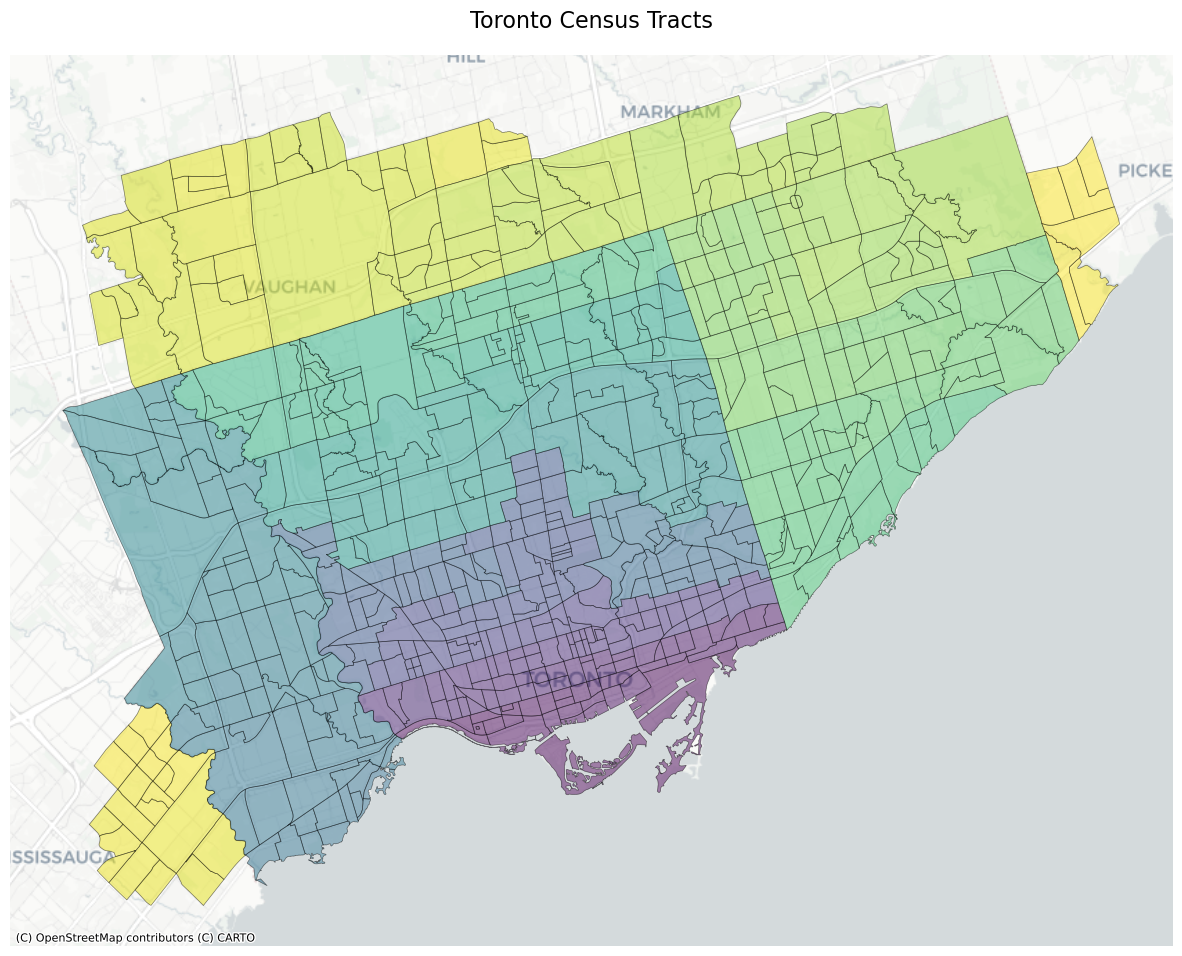

In [20]:
def download_census_tracts():
    """
    Downloads and extracts Toronto census tract boundaries.
    Returns the path to the extracted shapefile.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    
    print("Downloading census tract boundaries...")
    url = "https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip"
    zip_path = "data/census_tracts.zip"
    
    if not os.path.exists(zip_path):
        response = requests.get(url, stream=True)
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    return 'data/lct_000b21a_e.shp'

def get_toronto_tracts(shapefile_path):
    """Load and filter Toronto census tracts"""
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.to_crs('EPSG:4326')
    
    # Filter for Toronto area
    toronto_bounds = {
        'min_lat': 43.58,
        'max_lat': 43.85,
        'min_lon': -79.62,
        'max_lon': -79.12
    }
    
    toronto_mask = (
        gdf.geometry.centroid.y.between(toronto_bounds['min_lat'], toronto_bounds['max_lat']) &
        gdf.geometry.centroid.x.between(toronto_bounds['min_lon'], toronto_bounds['max_lon'])
    )
    
    return gdf[toronto_mask].copy()

def visualize_census_tracts(toronto_tracts):
    """Create visualization of census tracts"""
    # Convert to Web Mercator for the basemap
    toronto_tracts_web = toronto_tracts.to_crs(epsg=3857)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot tracts
    toronto_tracts_web.plot(
        ax=ax,
        alpha=0.5,
        edgecolor='black',
        linewidth=0.5,
        column='CTUID',
        cmap='viridis',
        legend=False
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Customize plot
    ax.set_axis_off()
    plt.title('Toronto Census Tracts', fontsize=16, pad=20)
    
    plt.show()
    
    return toronto_tracts

# Execute visualization
shapefile_path = download_census_tracts()
toronto_tracts = get_toronto_tracts(shapefile_path)
toronto_tracts = visualize_census_tracts(toronto_tracts)

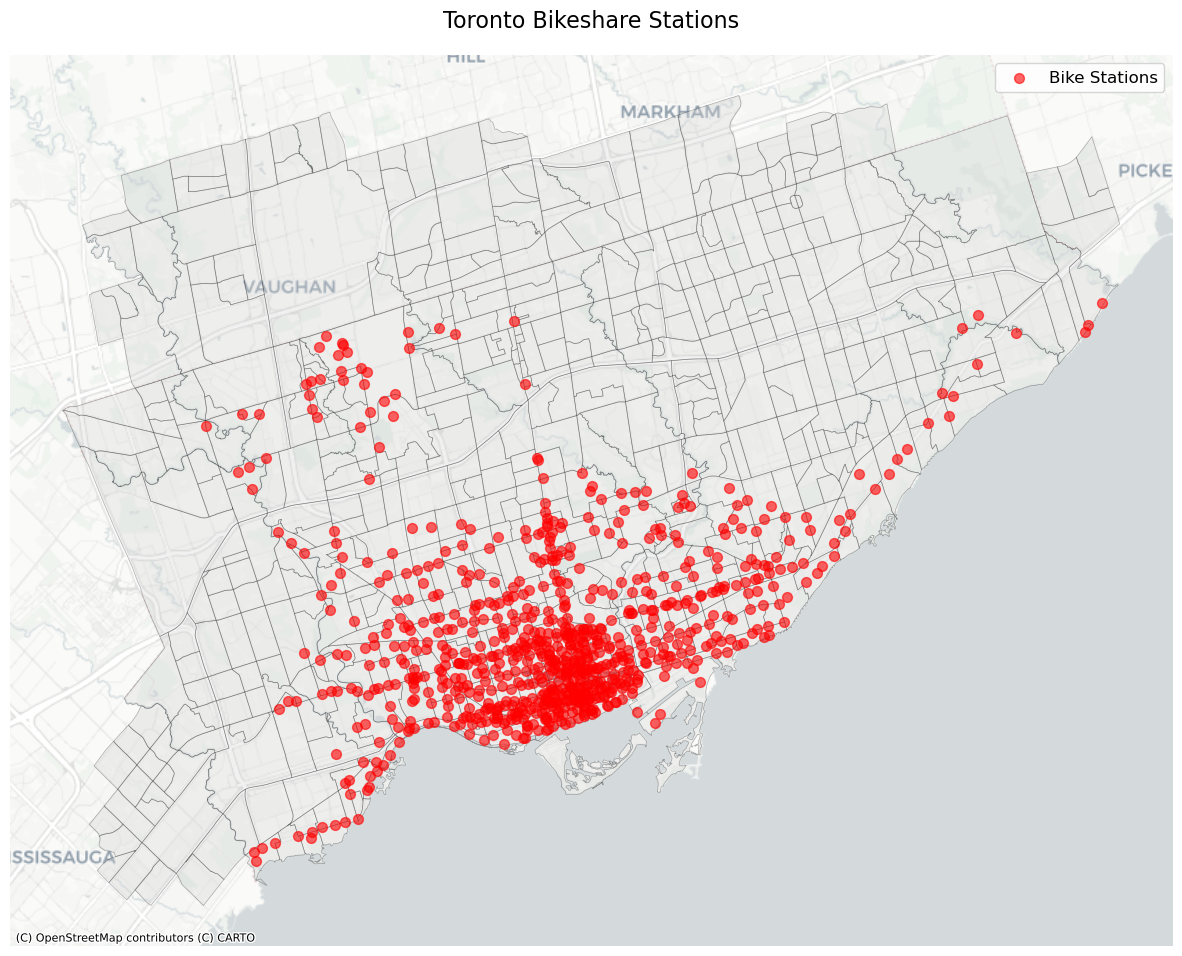


=== Toronto Bikeshare Station Statistics ===

Overall Summary:
Total number of stations: 797
Total number of census tracts: 678
Number of tracts with at least one station: 275
Percentage of tracts with stations: 40.6%
Average stations per tract (among tracts with stations): 2.90

Top 10 census tracts by number of stations:
Census Tract 5350014.0: 23 stations
Census Tract 5350035.0: 19 stations
Census Tract 5350061.0: 15 stations
Census Tract 5350008.02: 13 stations
Census Tract 5350011.01: 12 stations
Census Tract 5350016.0: 12 stations
Census Tract 5350311.06: 11 stations
Census Tract 5350001.0: 10 stations
Census Tract 5350010.02: 10 stations
Census Tract 5350050.03: 9 stations


In [27]:
def generate_station_statistics(stations_gdf, toronto_tracts, station_tract_map):
    """Generate basic statistics about stations and census tracts"""
    
    # Create a dataframe of stations per tract
    tract_stats = pd.DataFrame.from_dict(
        station_tract_map, 
        orient='index', 
        columns=['Census_Tract']
    )
    stations_per_tract = tract_stats['Census_Tract'].value_counts()
    
    # Calculate basic statistics
    total_stations = len(stations_gdf)
    total_tracts = len(toronto_tracts)
    tracts_with_stations = len(stations_per_tract)
    avg_stations_per_tract = stations_per_tract.mean()
    
    print("\n=== Toronto Bikeshare Station Statistics ===")
    print(f"\nOverall Summary:")
    print(f"Total number of stations: {total_stations}")
    print(f"Total number of census tracts: {total_tracts}")
    print(f"Number of tracts with at least one station: {tracts_with_stations}")
    print(f"Percentage of tracts with stations: {(tracts_with_stations/total_tracts)*100:.1f}%")
    print(f"Average stations per tract (among tracts with stations): {avg_stations_per_tract:.2f}")
    
    # Top 10 tracts by station count
    print("\nTop 10 census tracts by number of stations:")
    top_10_tracts = stations_per_tract.nlargest(10)
    for tract, count in top_10_tracts.items():
        print(f"Census Tract {tract}: {count} stations")

def visualize_stations_with_tracts(df, toronto_tracts):
    """
    Create visualization of bikeshare stations on top of census tracts
    and add census tract information to the dataframe with preserved decimals
    """
    # Get unique stations
    unique_stations = df[['Station_Name', 'Latitude', 'Longitude']].drop_duplicates()
    
    # Create GeoDataFrame for stations
    geometry = [Point(xy) for xy in zip(unique_stations['Longitude'], unique_stations['Latitude'])]
    stations_gdf = gpd.GeoDataFrame(
        unique_stations, 
        geometry=geometry,
        crs='EPSG:4326'
    )
    
    # Convert both to Web Mercator for visualization
    stations_web = stations_gdf.to_crs(epsg=3857)
    toronto_tracts_web = toronto_tracts.to_crs(epsg=3857)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot census tracts
    toronto_tracts_web.plot(
        ax=ax,
        alpha=0.3,
        edgecolor='black',
        linewidth=0.5,
        color='lightgray'
    )
    
    # Plot stations
    stations_web.plot(
        ax=ax,
        color='red',
        markersize=50,
        alpha=0.6,
        label='Bike Stations'
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Customize plot
    ax.set_axis_off()
    plt.title('Toronto Bikeshare Stations', fontsize=16, pad=20)
    plt.legend(fontsize=12)
    
    plt.show()
    
    # Process each unique station with decimal preservation
    station_tract_map = {}
    
    # Ensure toronto_tracts['CTUID'] is numeric
    toronto_tracts['CTUID'] = pd.to_numeric(toronto_tracts['CTUID'], errors='coerce')
    
    # Process each unique station
    for idx, station in unique_stations.iterrows():
        if station['Station_Name'] not in station_tract_map:
            point = Point(station['Longitude'], station['Latitude'])
            
            # Find which census tract contains this point
            for tract_idx, tract in toronto_tracts.iterrows():
                if tract.geometry.contains(point):
                    # Store as float with 2 decimal places
                    station_tract_map[station['Station_Name']] = float(f"{tract['CTUID']:.2f}")
                    break
    
    # Add census tract column to original dataframe
    df_with_tracts = df.copy()
    df_with_tracts['Census_Tract'] = df_with_tracts['Station_Name'].map(station_tract_map)
    
    # Ensure Census_Tract is stored as float64
    df_with_tracts['Census_Tract'] = df_with_tracts['Census_Tract'].astype('float64')
    
    # Generate statistics
    generate_station_statistics(stations_gdf, toronto_tracts, station_tract_map)
    
    return df_with_tracts

# Execute visualization and get updated dataframe
df_with_tracts = visualize_stations_with_tracts(df, toronto_tracts)

C:\Users\user\AppData\Local\Temp\ipykernel_8532\3202412175.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  toronto_tracts.geometry.centroid.y.between(downtown_bounds['min_lat'], downtown_bounds['max_lat']) &
C:\Users\user\AppData\Local\Temp\ipykernel_8532\3202412175.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  toronto_tracts.geometry.centroid.x.between(downtown_bounds['min_lon'], downtown_bounds['max_lon'])



Downtown Area Statistics:
Number of census tracts in view: 49
Number of bike stations in view: 285

Top 10 Downtown Census Tracts by Number of Stations:
Census Tract 5350014.0: 23 stations
Census Tract 5350035.0: 19 stations
Census Tract 5350061.0: 15 stations
Census Tract 5350011.01: 12 stations
Census Tract 5350016.0: 12 stations
Census Tract 5350037.0: 9 stations
Census Tract 5350036.0: 9 stations
Census Tract 5350013.01: 9 stations
Census Tract 5350034.02: 9 stations
Census Tract 5350017.01: 8 stations


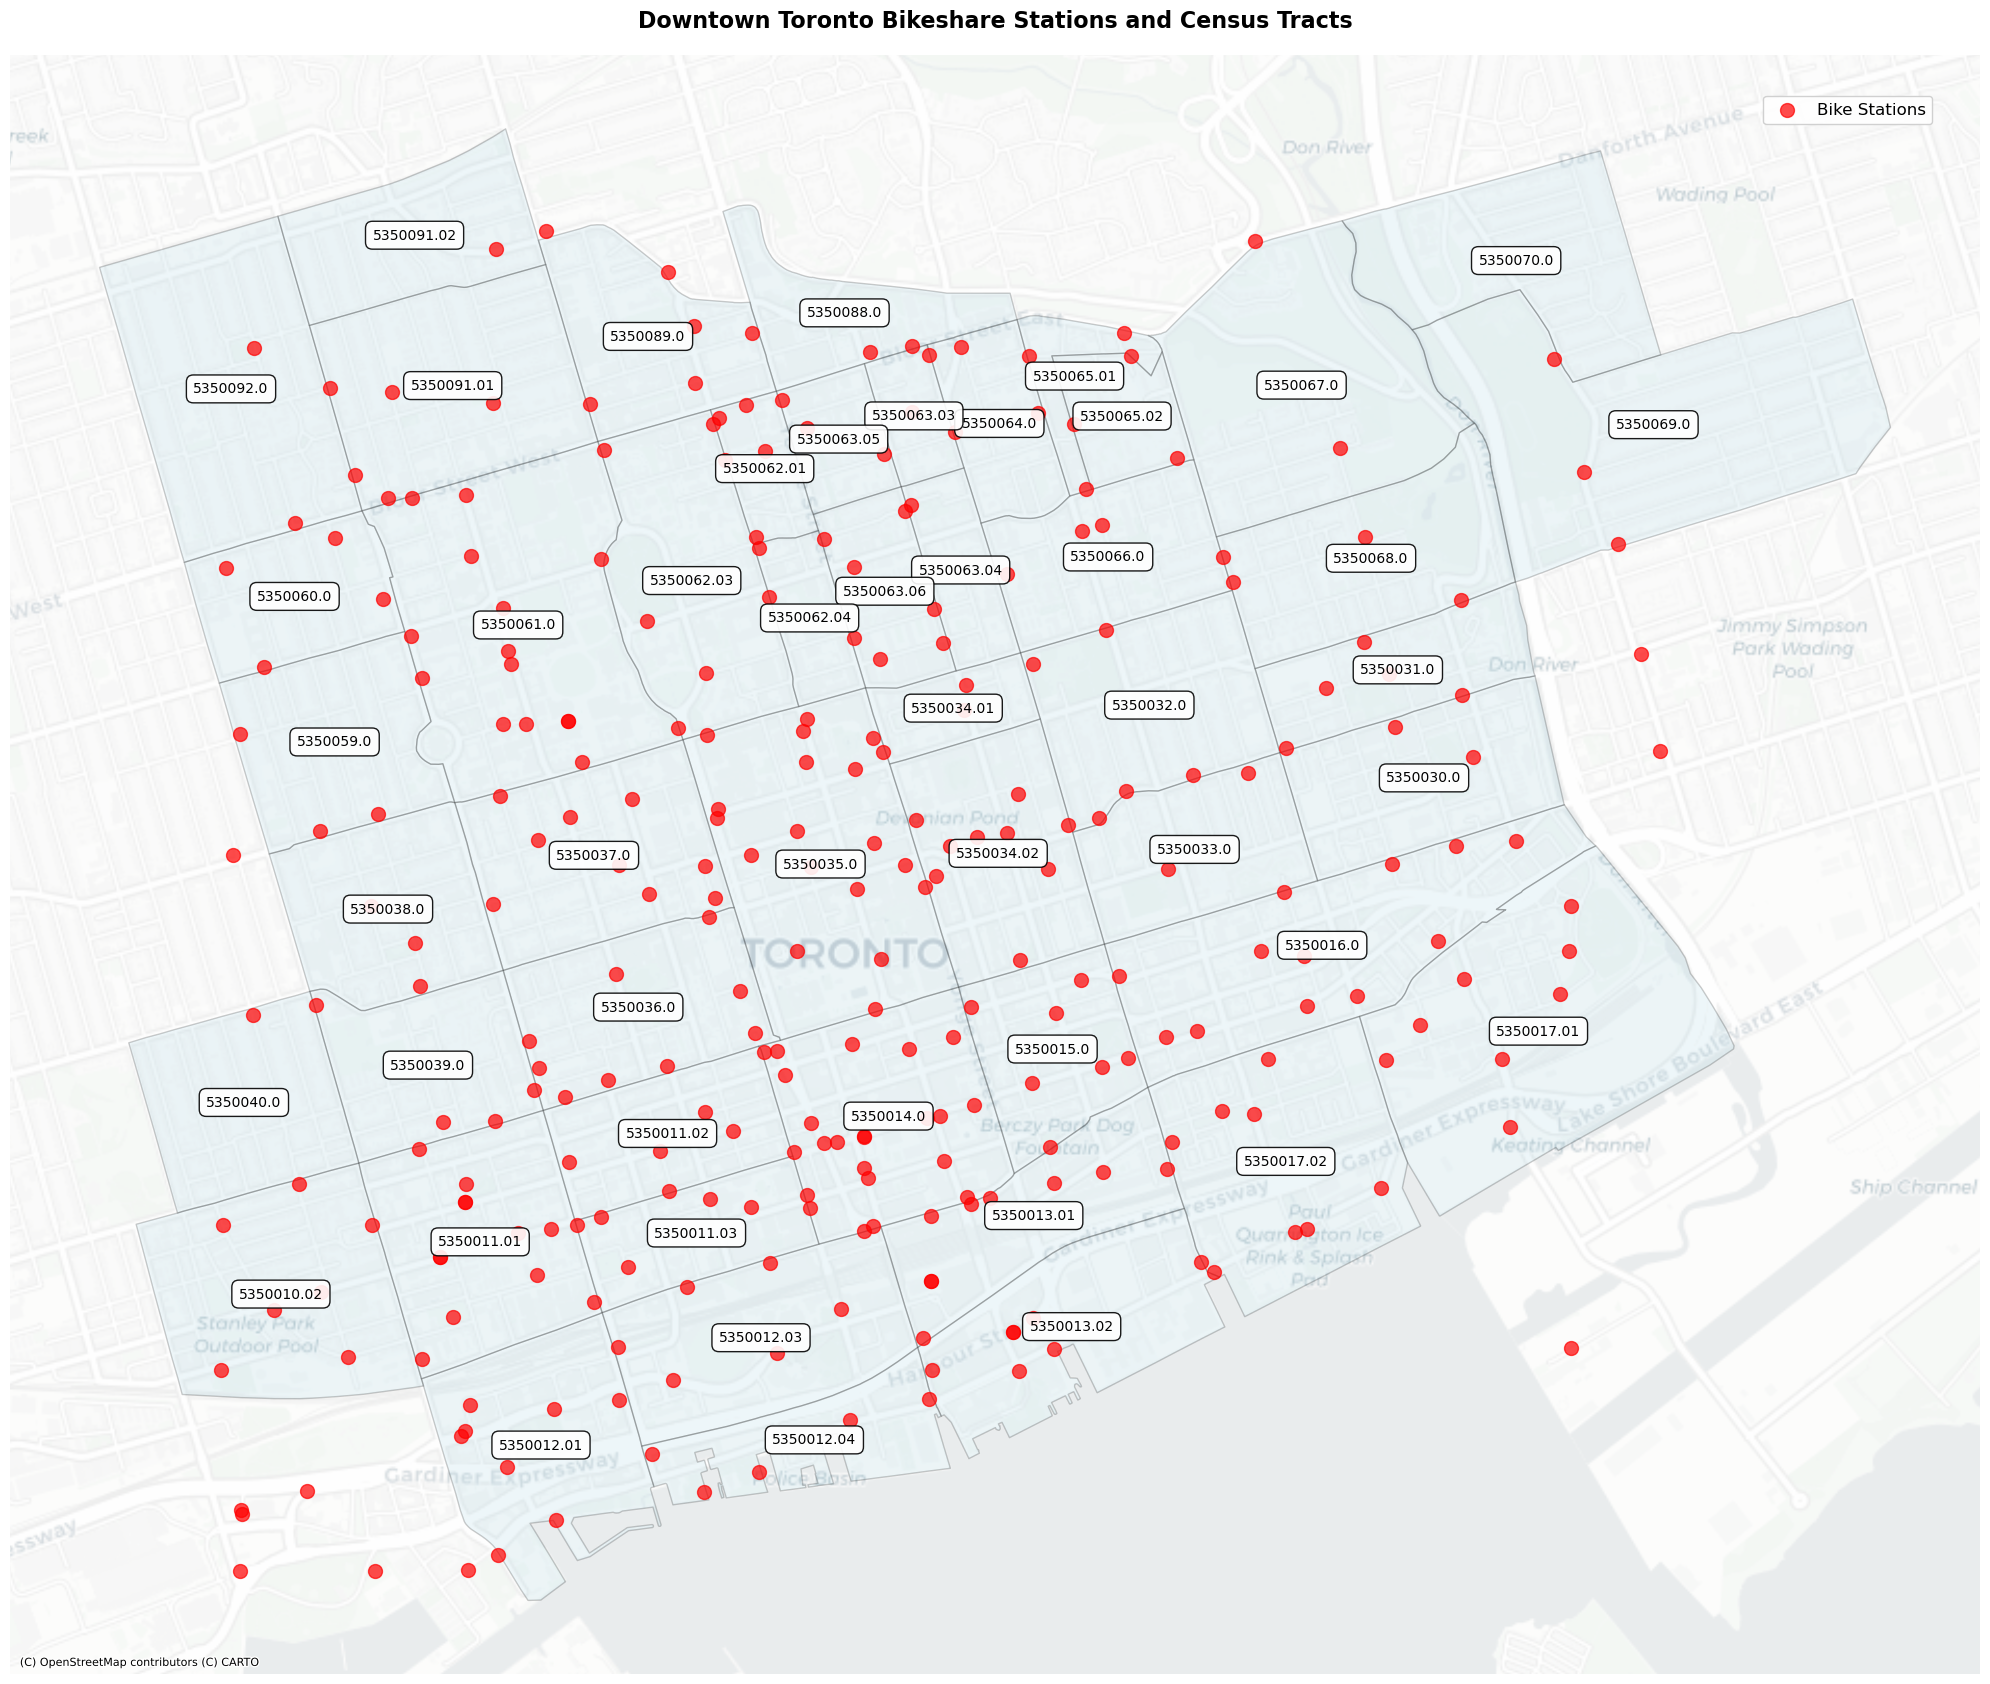

In [29]:
def visualize_downtown_tracts_improved(toronto_tracts, df, figsize=(20, 20)):
    """
    Create an improved detailed map focusing on downtown Toronto census tracts and stations.
    Includes better bounds and improved visibility.
    """
    # Define downtown bounds - expanded slightly for better coverage
    downtown_bounds = {
        'min_lat': 43.635,
        'max_lat': 43.675,
        'min_lon': -79.410,
        'max_lon': -79.350
    }
    
    # Filter for downtown tracts
    downtown_mask = (
        toronto_tracts.geometry.centroid.y.between(downtown_bounds['min_lat'], downtown_bounds['max_lat']) &
        toronto_tracts.geometry.centroid.x.between(downtown_bounds['min_lon'], downtown_bounds['max_lon'])
    )
    downtown_tracts = toronto_tracts[downtown_mask].copy()
    
    # Filter stations in downtown area
    downtown_stations = df[
        (df['Latitude'].between(downtown_bounds['min_lat'], downtown_bounds['max_lat'])) &
        (df['Longitude'].between(downtown_bounds['min_lon'], downtown_bounds['max_lon']))
    ].drop_duplicates(subset=['Station_Name']).copy()
    
    # Create GeoDataFrame for stations
    geometry = [Point(xy) for xy in zip(downtown_stations['Longitude'], downtown_stations['Latitude'])]
    stations_gdf = gpd.GeoDataFrame(
        downtown_stations, 
        geometry=geometry,
        crs='EPSG:4326'
    )
    
    # Add census tract information to stations
    for idx, station in stations_gdf.iterrows():
        point = station.geometry
        for tract_idx, tract in downtown_tracts.iterrows():
            if tract.geometry.contains(point):
                stations_gdf.loc[idx, 'Census_Tract'] = tract['CTUID']
                break
    
    # Convert to Web Mercator for visualization
    stations_gdf = stations_gdf.to_crs(epsg=3857)
    downtown_tracts = downtown_tracts.to_crs(epsg=3857)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot census tracts with better visibility
    downtown_tracts.plot(
        ax=ax,
        alpha=0.2,
        edgecolor='black',
        linewidth=1,
        color='lightblue'
    )
    
    # Plot stations with better visibility
    stations_gdf.plot(
        ax=ax,
        color='red',
        markersize=100,
        alpha=0.7,
        label='Bike Stations'
    )
    
    # Add census tract numbers with improved visibility
    for idx, tract in downtown_tracts.iterrows():
        centroid = tract.geometry.centroid
        ax.text(
            centroid.x, 
            centroid.y, 
            tract['CTUID'],
            fontsize=10,
            ha='center',
            va='center',
            bbox=dict(
                facecolor='white',
                alpha=0.9,
                edgecolor='black',
                boxstyle='round,pad=0.5'
            )
        )
    
    # Add basemap with better contrast
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        alpha=0.5
    )
    
    # Customize plot
    ax.set_axis_off()
    plt.title('Downtown Toronto Bikeshare Stations and Census Tracts', 
              fontsize=16, 
              pad=20,
              fontweight='bold')
    
    # Add legend with better positioning
    legend = plt.legend(
        fontsize=12,
        loc='upper right',
        bbox_to_anchor=(0.98, 0.98)
    )
    legend.get_frame().set_alpha(0.9)
    
    # Print statistics
    print("\nDowntown Area Statistics:")
    print(f"Number of census tracts in view: {len(downtown_tracts)}")
    print(f"Number of bike stations in view: {len(stations_gdf)}")
    
    # Show stations per tract
    if 'Census_Tract' in stations_gdf.columns:
        stations_per_tract = stations_gdf['Census_Tract'].value_counts()
        print("\nTop 10 Downtown Census Tracts by Number of Stations:")
        for tract, count in stations_per_tract.head(10).items():
            print(f"Census Tract {tract}: {count} stations")
    
    plt.tight_layout()
    return fig, ax

# Execute the improved visualization
fig, ax = visualize_downtown_tracts_improved(toronto_tracts, df_with_tracts)

In [30]:
df_with_tracts.to_csv('Hourly outflow with census tract.csv', index=False)

In [31]:
df = pd.read_csv('Hourly outflow with census tract.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000848 entries, 0 to 7000847
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DateTime           object 
 1   Date               object 
 2   Year               int64  
 3   Month              object 
 4   Month_Num          int64  
 5   Day_of_Week        object 
 6   Day_of_Week_Num    int64  
 7   Hour               int64  
 8   Is_Weekend         int64  
 9   Time_Period        object 
 10  Station_Name       object 
 11  User Type          object 
 12  Model              object 
 13  Outflow_Count      float64
 14  MA_3H              float64
 15  MA_24H             float64
 16  MA_Week            float64
 17  Latitude           float64
 18  Longitude          float64
 19  Temperature        float64
 20  Dew Point          float64
 21  Relative Humidity  float64
 22  Precipitation      float64
 23  Wind Direction     float64
 24  Wind Speed         float64
 25  Pressure          

# Toronto Bikeshare System Exploratory Data Analysis
## Comprehensive Analysis of Usage Patterns and Influencing Factors

This notebook performs an in-depth exploratory data analysis of Toronto's bikeshare system, focusing on station outflows and various influencing factors.

### Dataset Overview

The processed dataset contains 7,000,848 hourly records with 28 columns, including:
- Temporal features (DateTime, Date, Year, Month, Hour, etc.)
- Station information (Name, Latitude, Longitude, Census Tract)
- Usage metrics (Outflow Count, Moving Averages)
- Weather conditions (Temperature, Precipitation, Wind, etc.)


### Exploratory Data Analysis Components

The `perform_eda()` function conducts a comprehensive analysis across five main areas:

#### 1. Overall System Usage Analysis
- Total system outflows
- Average daily trips
- Distribution by user type
- Distribution by bike model
- Temporal trends visualization with moving averages:
  - 3-hour MA (short-term patterns)
  - 24-hour MA (daily patterns)
  - Weekly MA (long-term trends)

#### 2. Station and Census Tract Analysis
- Top 15 busiest stations with their census tracts
- Top 10 busiest census tracts
- Station usage distribution visualization
- Box plots of hourly outflows for top stations

#### 3. Temporal Patterns Analysis
Visualizations and statistics for:
- Hourly patterns by user type
- Daily patterns (weekday vs weekend)
- Monthly trends
- Time period distribution (Morning, Midday, Evening, Night)

#### 4. Weather Impact Analysis
- Correlation analysis between weather variables and outflows
- Correlation matrix visualization
- Temperature impact by user type
- Precipitation effects
- Wind speed influence
- Weather variable relationships:
  - Temperature
  - Precipitation
  - Wind Speed
  - Cloud Cover
  - Dew Point
  - Relative Humidity
  - Pressure

#### 5. Census Tract Usage Patterns
- Average usage patterns by tract
- Temporal variations across different tracts
- Geographic distribution of demand
- Top 5 census tracts hourly patterns

### Visualization Details

All visualizations are created using:
- Seaborn with 'husl' color palette
- Matplotlib with 'seaborn-v0_8' style
- Standardized figure sizes for consistency
- Clear titles, labels, and legends
- Grid lines for better readability

### Key Findings and Statistics

The analysis reveals:
1. System Usage:
   - Total outflows and daily averages
   - User type distribution
   - Bike model preferences

2. Spatial Patterns:
   - High-demand stations and areas
   - Census tract usage patterns
   - Geographic clustering of demand

3. Temporal Trends:
   - Peak usage hours
   - Weekday vs weekend patterns
   - Seasonal variations

4. Weather Impacts:
   - Temperature correlations
   - Precipitation effects
   - Weather variable relationships

### Usage for Demand Forecasting

This EDA provides crucial insights for demand forecasting by:
1. Identifying key demand drivers
2. Understanding temporal patterns
3. Quantifying weather impacts
4. Recognizing spatial dependencies
5. Revealing user behavior patterns

The findings from this analysis can inform feature selection and model development for the demand forecasting system.


Overall System Usage Analysis
Total Outflows: 5,336,042
Average Daily Outflows: 14579.3

Outflows by User Type:
Annual Member: 243,772 trips (4.57%)
Casual Member: 5,092,270 trips (95.43%)

Outflows by Bike Model:
EFIT: 23,673 trips (0.44%)
EFIT G5: 49,034 trips (0.92%)
ICONIC: 833,828 trips (15.63%)
unknown: 4,429,507 trips (83.01%)

Value Ranges:
Outflow_Count:
  Min: 0.14
  Max: 1.32
  Mean: 0.76
MA_3H:
  Min: 0.14
  Max: 1.32
  Mean: 0.76
MA_24H:
  Min: 0.16
  Max: 1.27
  Mean: 0.76
MA_Week:
  Min: 0.21
  Max: 1.22
  Mean: 0.76


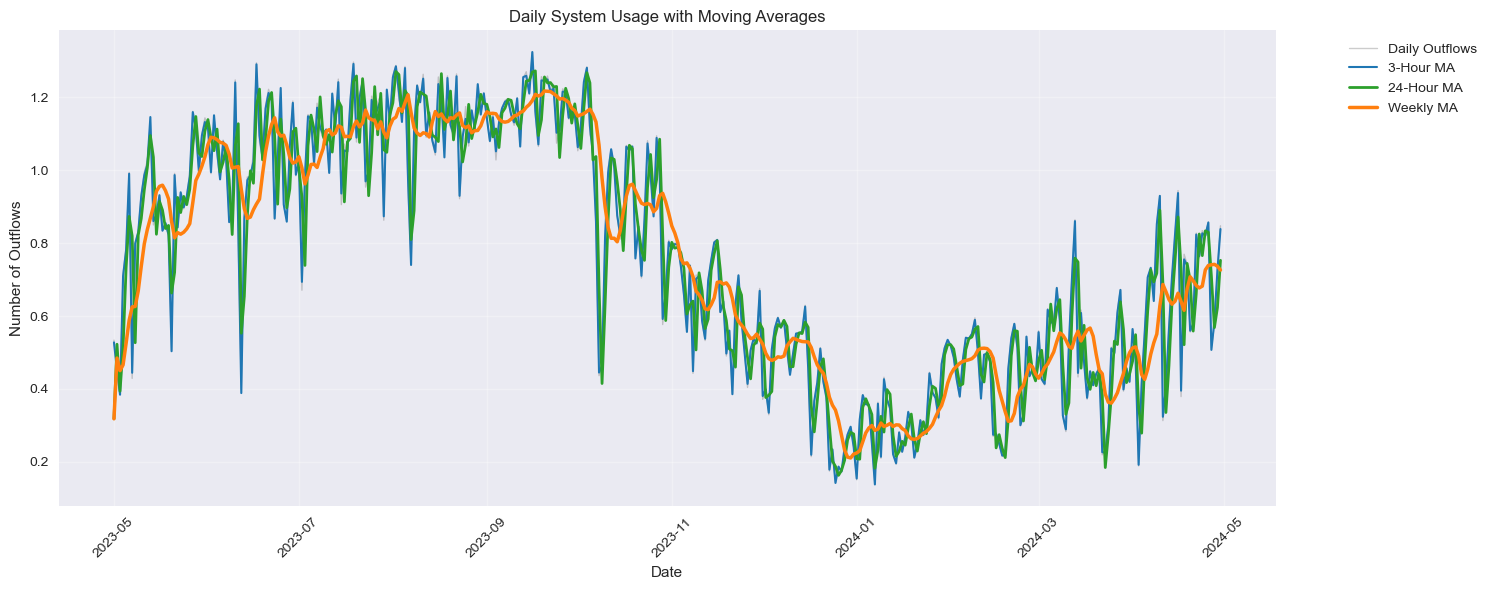


Station and Census Tract Analysis

Top 15 Busiest Stations:
Bay St / College St (East Side) (Census Tract: 5350035.0): 43,022 outflows
King St W / Brant St (Census Tract: 5350011.01): 42,493 outflows
Union Station (Census Tract: 5350013.01): 39,692 outflows
York St / Queens Quay W (Census Tract: 5350012.04): 39,284 outflows
Bay St / Wellesley St W (Census Tract: 5350062.03): 37,194 outflows
Queen St W / John St (Census Tract: 5350036.0): 33,759 outflows
Dundas St W / Yonge St (Census Tract: 5350035.0): 32,538 outflows
College Park - Yonge St Entrance (Census Tract: 5350035.0): 32,081 outflows
Richmond St E / Yonge St (Census Tract: 5350015.0): 31,650 outflows
Simcoe St / Queen St W (Census Tract: 5350014.0): 31,223 outflows
College St / Major St (Census Tract: 5350059.0): 29,829 outflows
St. George St / Bloor St W (Census Tract: 5350061.0): 29,331 outflows
Dundas St E / Regent Park Blvd (Census Tract: 5350030.0): 28,937 outflows
Spadina Ave / Harbord St - SMART (Census Tract: 5350061.

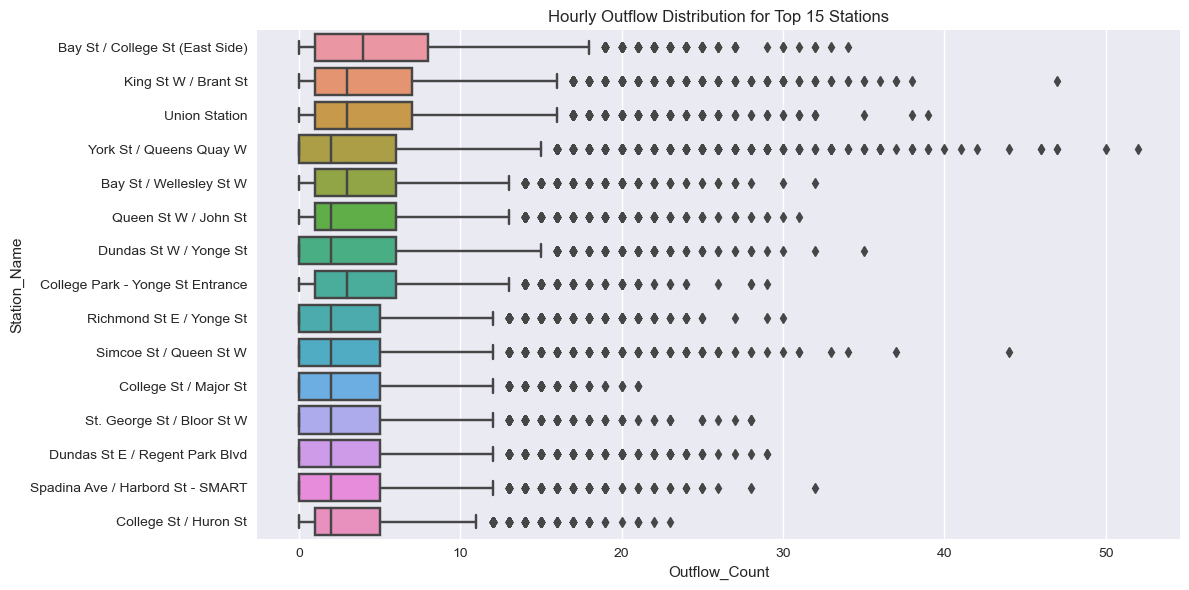


Temporal Patterns Analysis


<Figure size 1200x600 with 0 Axes>

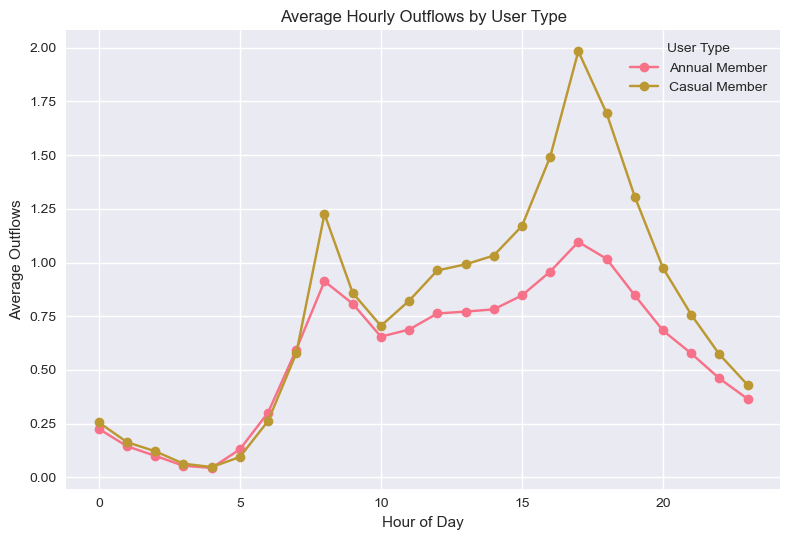

<Figure size 1200x600 with 0 Axes>

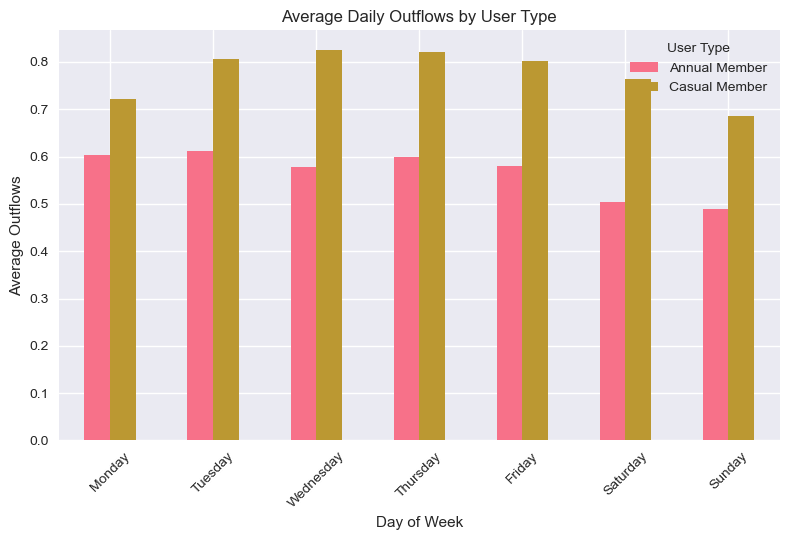


Weather Impact Analysis

Correlations with Outflows:
Outflow_Count        1.000000
Temperature          0.173880
Dew Point            0.147694
Pressure             0.013557
Precipitation       -0.019541
Cloud Cover         -0.028732
Wind Speed          -0.042877
Relative Humidity   -0.048171
Name: Outflow_Count, dtype: float64


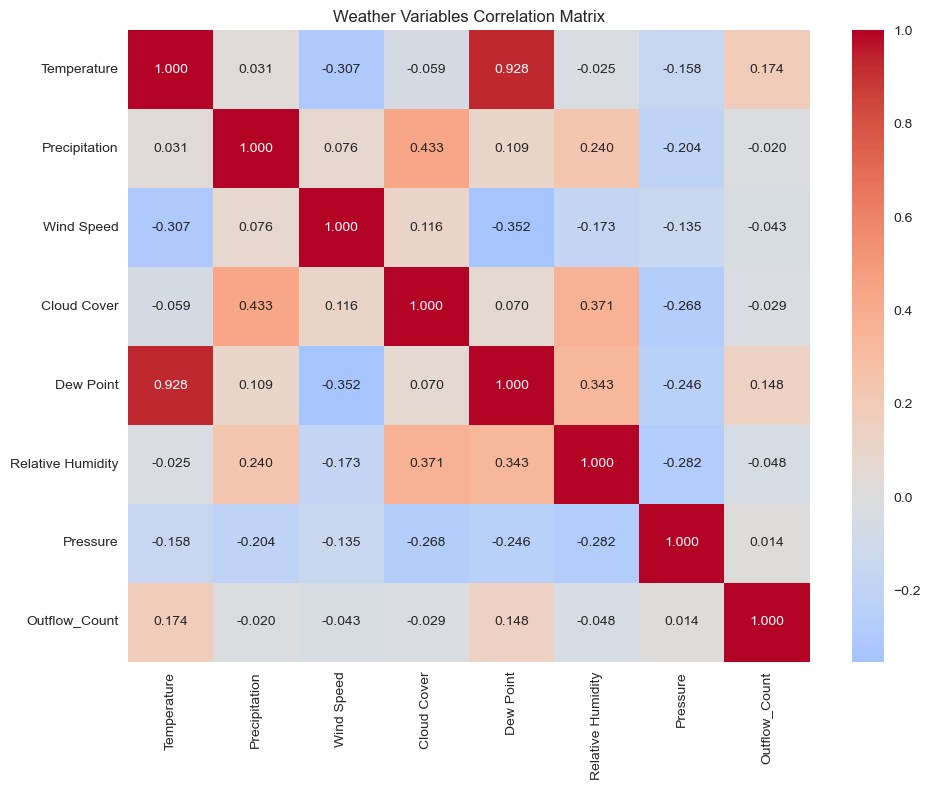

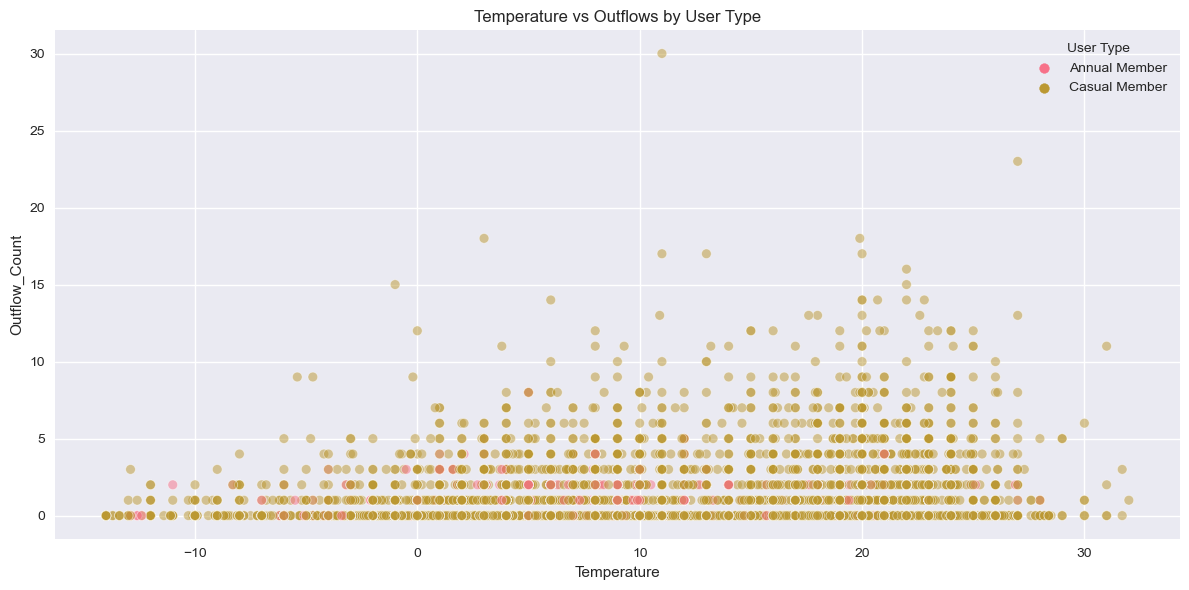


Census Tract Usage Patterns


<Figure size 1200x600 with 0 Axes>

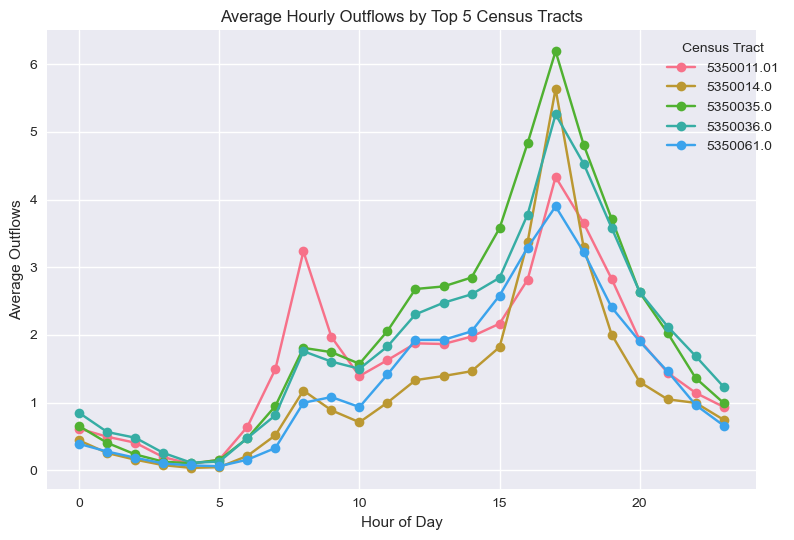

In [33]:
def perform_eda(df):
    """
    Performs comprehensive exploratory data analysis focusing on outflow patterns.
    """
    # Create a copy and convert DateTime
    df = df.copy()
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # Set plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    def print_section(title):
        print("\n" + "="*50)
        print(title)
        print("="*50)
    
    # 1. Overall System Usage
    print_section("Overall System Usage Analysis")
    
    # Total trips and averages
    total_trips = df['Outflow_Count'].sum()
    avg_daily_trips = df.groupby(df['DateTime'].dt.date)['Outflow_Count'].sum().mean()
    print(f"Total Outflows: {total_trips:,.0f}")
    print(f"Average Daily Outflows: {avg_daily_trips:.1f}")
    
    # User Type Distribution
    print("\nOutflows by User Type:")
    user_dist = df.groupby('User Type')['Outflow_Count'].sum()
    user_dist_pct = (user_dist / user_dist.sum() * 100).round(2)
    for user_type, pct in user_dist_pct.items():
        print(f"{user_type}: {user_dist[user_type]:,.0f} trips ({pct}%)")
    
    # Bike Model Distribution
    print("\nOutflows by Bike Model:")
    model_dist = df.groupby('Model')['Outflow_Count'].sum()
    model_dist_pct = (model_dist / model_dist.sum() * 100).round(2)
    for model, pct in model_dist_pct.items():
        print(f"{model}: {model_dist[model]:,.0f} trips ({pct}%)")
    
    # Plot daily usage pattern
    # Convert DateTime to datetime type if not already
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Create the plot
    plt.figure(figsize=(15, 6))

    # Calculate daily aggregates for outflows
    daily_data = df.groupby(df['DateTime'].dt.date).agg({
        'Outflow_Count': 'sum',
         'MA_3H': 'sum',        # Sum instead of mean to match the scale
         'MA_24H': 'sum',       # Sum instead of mean to match the scale
     'MA_Week': 'sum'       # Sum instead of mean to match the scale
     }).div(df.groupby(df['DateTime'].dt.date).size(), axis=0)  # Divide by number of records per day

    # Plot raw data and moving averages
    daily_data['Outflow_Count'].plot(color='gray', alpha=0.4, label='Daily Outflows', linewidth=1)
    daily_data['MA_3H'].plot(color='#1f77b4', label='3-Hour MA', linewidth=1.5)
    daily_data['MA_24H'].plot(color='#2ca02c', label='24-Hour MA', linewidth=2)
    daily_data['MA_Week'].plot(color='#ff7f0e', label='Weekly MA', linewidth=2.5)

    plt.title('Daily System Usage with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Number of Outflows')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Print some statistics to verify the scales
    print("\nValue Ranges:")
    for col in daily_data.columns:
        print(f"{col}:")
        print(f"  Min: {daily_data[col].min():.2f}")
        print(f"  Max: {daily_data[col].max():.2f}")
        print(f"  Mean: {daily_data[col].mean():.2f}")

    plt.show() 

    # 2. Station and Census Tract Analysis
    print_section("Station and Census Tract Analysis")
    
    # Station statistics
    station_stats = df.groupby(['Station_Name', 'Census_Tract'])['Outflow_Count'].sum().sort_values(ascending=False)
    
    print("\nTop 15 Busiest Stations:")
    for station, outflows in station_stats.head(15).items():
        print(f"{station[0]} (Census Tract: {station[1]}): {outflows:,.0f} outflows")
    
    # Census tract statistics
    print("\nTop 10 Busiest Census Tracts:")
    tract_stats = df.groupby('Census_Tract')['Outflow_Count'].sum().sort_values(ascending=False)
    for tract, outflows in tract_stats.head(10).items():
        print(f"Census Tract {tract}: {outflows:,.0f} outflows")
    
    # Plot station usage distribution
    plt.figure(figsize=(12, 6))
    top_15_stations = station_stats.head(15).index.get_level_values('Station_Name')
    station_data = df[df['Station_Name'].isin(top_15_stations)]
    sns.boxplot(data=station_data, y='Station_Name', x='Outflow_Count',
                order=top_15_stations)
    plt.title('Hourly Outflow Distribution for Top 15 Stations')
    plt.tight_layout()
    plt.show()
    
    # 3. Temporal Patterns
    print_section("Temporal Patterns Analysis")
    
    # Hourly patterns by user type
    plt.figure(figsize=(12, 6))
    hourly_by_type = df.groupby(['Hour', 'User Type'])['Outflow_Count'].mean().unstack()
    hourly_by_type.plot(marker='o')
    plt.title('Average Hourly Outflows by User Type')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Outflows')
    plt.legend(title='User Type')
    plt.tight_layout()
    plt.show()
    
    # Daily patterns by user type
    plt.figure(figsize=(12, 6))
    df['Day_Name'] = df['DateTime'].dt.strftime('%A')
    daily_by_type = df.groupby(['Day_Name', 'User Type'])['Outflow_Count'].mean().unstack()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_by_type = daily_by_type.reindex(days_order)
    daily_by_type.plot(kind='bar')
    plt.title('Average Daily Outflows by User Type')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Outflows')
    plt.legend(title='User Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Weather Impact Analysis
    print_section("Weather Impact Analysis")
    
    weather_vars = ['Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 
                    'Dew Point', 'Relative Humidity', 'Pressure']
    
    # Correlation analysis
    corr_matrix = df[weather_vars + ['Outflow_Count']].corr()
    print("\nCorrelations with Outflows:")
    print(corr_matrix['Outflow_Count'].sort_values(ascending=False))
    
    # Weather correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
    plt.title('Weather Variables Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Temperature impact by user type
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df.sample(10000), x='Temperature', y='Outflow_Count', 
                    hue='User Type', alpha=0.5)
    plt.title('Temperature vs Outflows by User Type')
    plt.tight_layout()
    plt.show()
    
    # 5. Usage Patterns by Census Tract
    print_section("Census Tract Usage Patterns")
    
    # Average usage by time of day for top census tracts
    top_5_tracts = tract_stats.head(5).index
    tract_hourly = df[df['Census_Tract'].isin(top_5_tracts)].groupby(
        ['Hour', 'Census_Tract']
    )['Outflow_Count'].mean().unstack()
    
    plt.figure(figsize=(12, 6))
    tract_hourly.plot(marker='o')
    plt.title('Average Hourly Outflows by Top 5 Census Tracts')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Outflows')
    plt.legend(title='Census Tract', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# Execute the analysis
perform_eda(df)